# Spatial Autocorrelation

In [118]:
import numpy as np
import pandas as pd
import geopandas as gpd
from dask.distributed import Client
import s1_rtc_bs_utils
import py3dep
import geopandas as gpd
import rasterio as rio
import pystac
import pystac_client
import stackstac
import math
import shapely
import matplotlib.pyplot as plt
import os
import xarray as xr
from datetime import datetime
import ulmo
from datetime import datetime
import sys
from pysal.explore import esda   # Exploratory Spatial analytics
from pysal.lib import weights
from pysal.viz import splot
from splot.esda import plot_moran
import seaborn
import skgstat as skg

In [2]:
# GDAL environment variables for better performance
os.environ['AWS_REGION']='us-west-2'
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='EMPTY_DIR' 
os.environ['AWS_NO_SIGN_REQUEST']='YES' 
#
xr.set_options(keep_attrs=True)
# Paste /proxy/localhost:8787 for cluster diagnostics
client = Client(local_directory='/tmp', processes=False)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://172.25.45.79:37213/status,
Dashboard: http://172.25.45.79:37213/status,Workers: 1
Total threads: 32,Total memory: 125.71 GiB
Status: running,Using processes: False
Comm: inproc://172.25.45.79/721323/1,Workers: 1
Dashboard: http://172.25.45.79:37213/status,Total threads: 32
Started: Just now,Total memory: 125.71 GiB
Comm: inproc://172.25.45.79/721323/4,Total threads: 32
Dashboard: http://172.25.45.79:37487/status,Memory: 125.71 GiB
Nanny: None,


In [3]:
rainier_bbox_gdf = gpd.read_file('shapefiles/mt_rainier.geojson')

In [4]:
rainier_sar_ds=s1_rtc_bs_utils.get_s1_rtc_stac(rainier_bbox_gdf,start_time='2020-01-01',end_time='2021-01-01',orbit_direction='all',polarization='gamma0_vv',collection='mycollection.json')

In [5]:
%%time
# compute frames, drop missing data
rainier_sar_ds = rainier_sar_ds.compute()
rainier_sar_ds = rainier_sar_ds.dropna('time',how='all')

CPU times: user 6.43 s, sys: 727 ms, total: 7.16 s
Wall time: 5.6 s


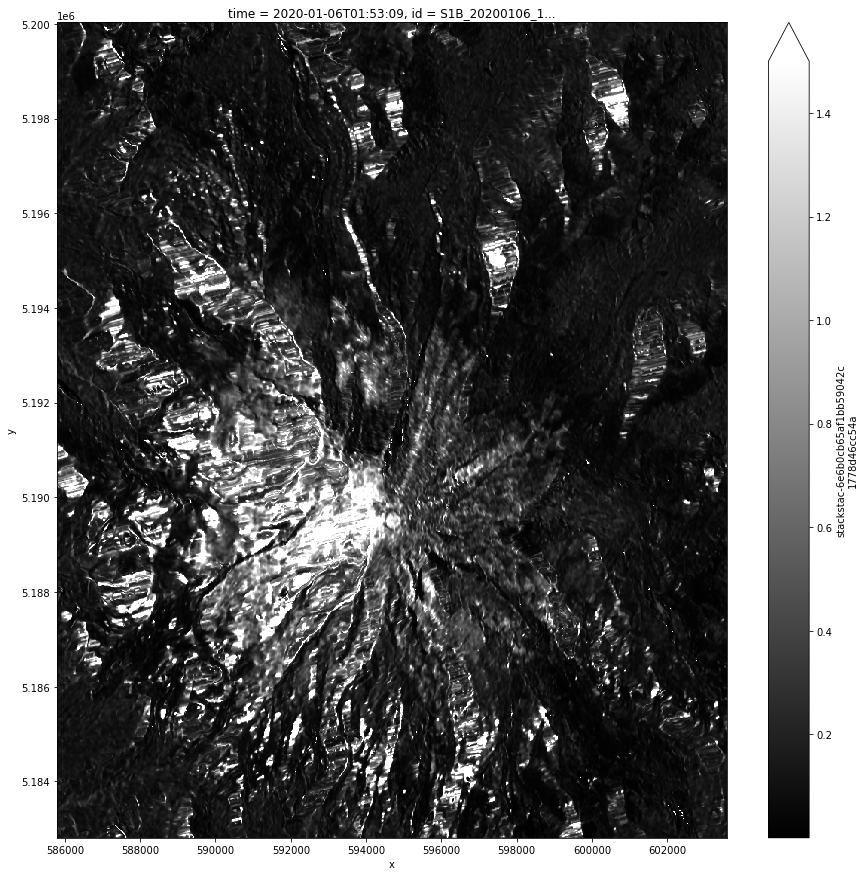

In [6]:
f,ax=plt.subplots(figsize=(15,15))
rainier_sar_ds.isel(time=0).plot(ax=ax,vmax=1.5,cmap='gray')

In [7]:
dem = s1_rtc_bs_utils.get_py3dep_dem(rainier_sar_ds)
aspect = s1_rtc_bs_utils.get_py3dep_aspect(rainier_sar_ds)
slope = s1_rtc_bs_utils.get_py3dep_slope(rainier_sar_ds)
dah = s1_rtc_bs_utils.get_dah(rainier_sar_ds)

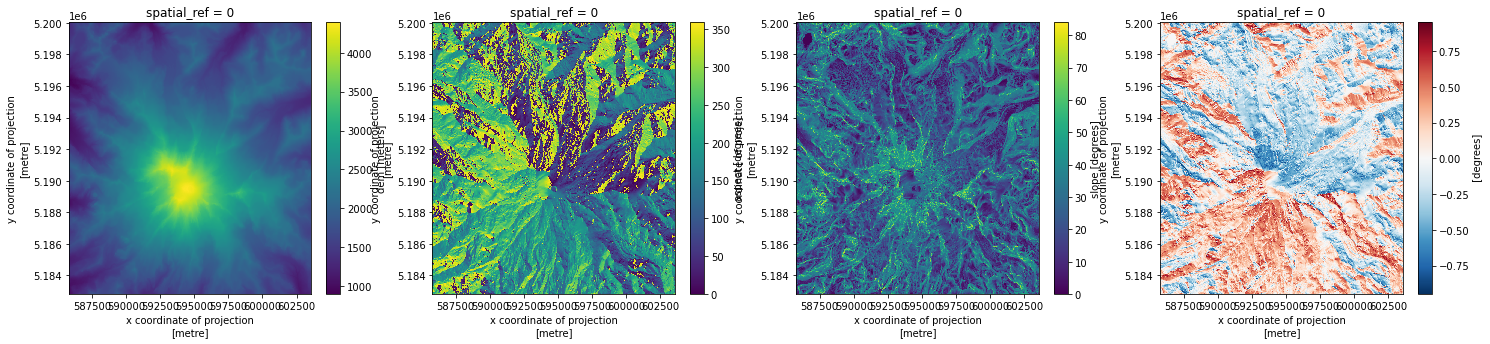

In [8]:
f,ax=plt.subplots(1,4,figsize=(25,5))
dem.plot(ax=ax[0])
aspect.plot(ax=ax[1])
slope.plot(ax=ax[2])
dah.plot(ax=ax[3])

In [9]:
summer_ndvi_ds = s1_rtc_bs_utils.get_median_ndvi(rainier_sar_ds)

In [10]:
stats_full_df = s1_rtc_bs_utils.get_stats(rainier_sar_ds,dem=dem,aspect=aspect,dah=dah)
stats_ndvi_mask_df = s1_rtc_bs_utils.get_stats(rainier_sar_ds.where(summer_ndvi_ds<0.2,drop=True),dem=dem,aspect=aspect,dah=dah)
rainier_glaciers = gpd.read_file('shapefiles/rainier_glaciers.geojson').to_crs(rainier_sar_ds.crs)
stats_glacier_mask_df = s1_rtc_bs_utils.get_stats(rainier_sar_ds.rio.clip(rainier_glaciers.geometry,rainier_glaciers.crs,drop=False,invert=False),dem=dem,aspect=aspect,dah=dah)

In [76]:
stats_full_ds = stats_full_df.to_xarray()
stats_ndvi_mask_ds = stats_ndvi_mask_df.to_xarray()
stats_glacier_mask_ds = stats_glacier_mask_df.to_xarray()

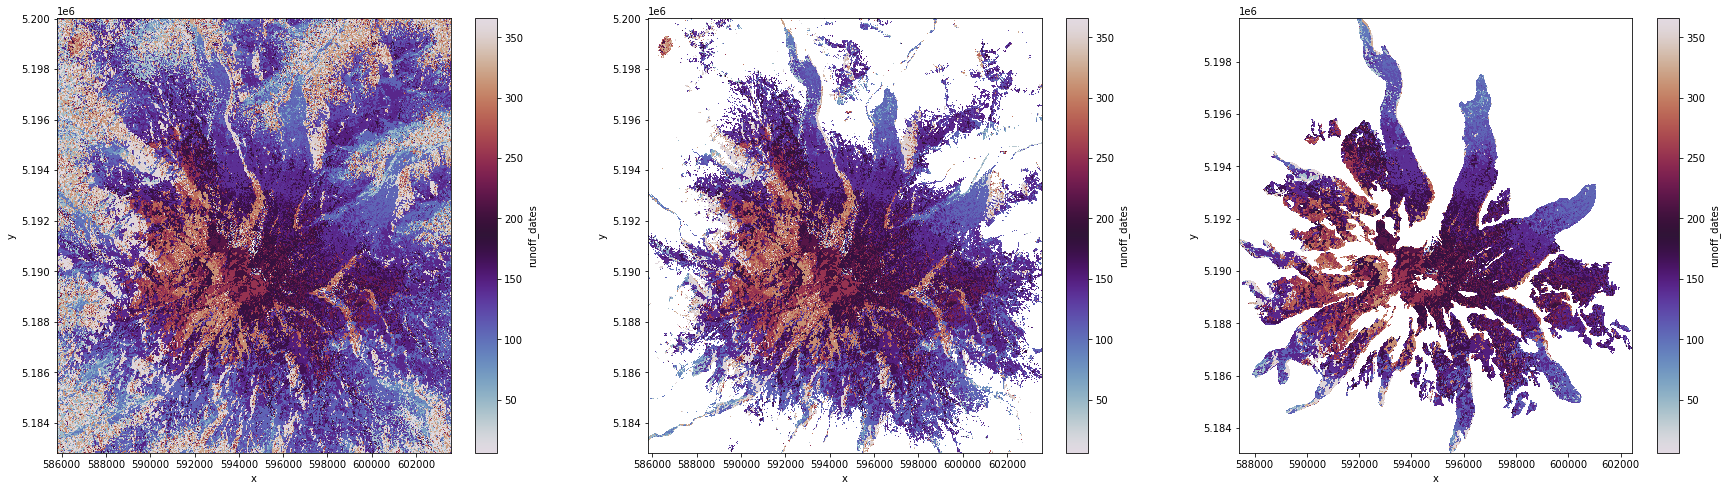

In [77]:
f,ax=plt.subplots(1,3,figsize=(30,8))

stats_full_ds['runoff_dates'].plot(ax=ax[0],cmap='twilight')
stats_ndvi_mask_ds['runoff_dates'].plot(ax=ax[1],cmap='twilight')
stats_glacier_mask_ds['runoff_dates'].plot(ax=ax[2],cmap='twilight')

In [55]:
def get_semivariogram(stats_df,variable,sampling_frac=.001):
    stats_df = stats_df.sample(frac=sampling_frac)
    V = skg.Variogram(list(zip(stats_df.geometry.y, stats_df.geometry.x)), stats_df[variable],n_lags=60,use_nugget=True)
    return V

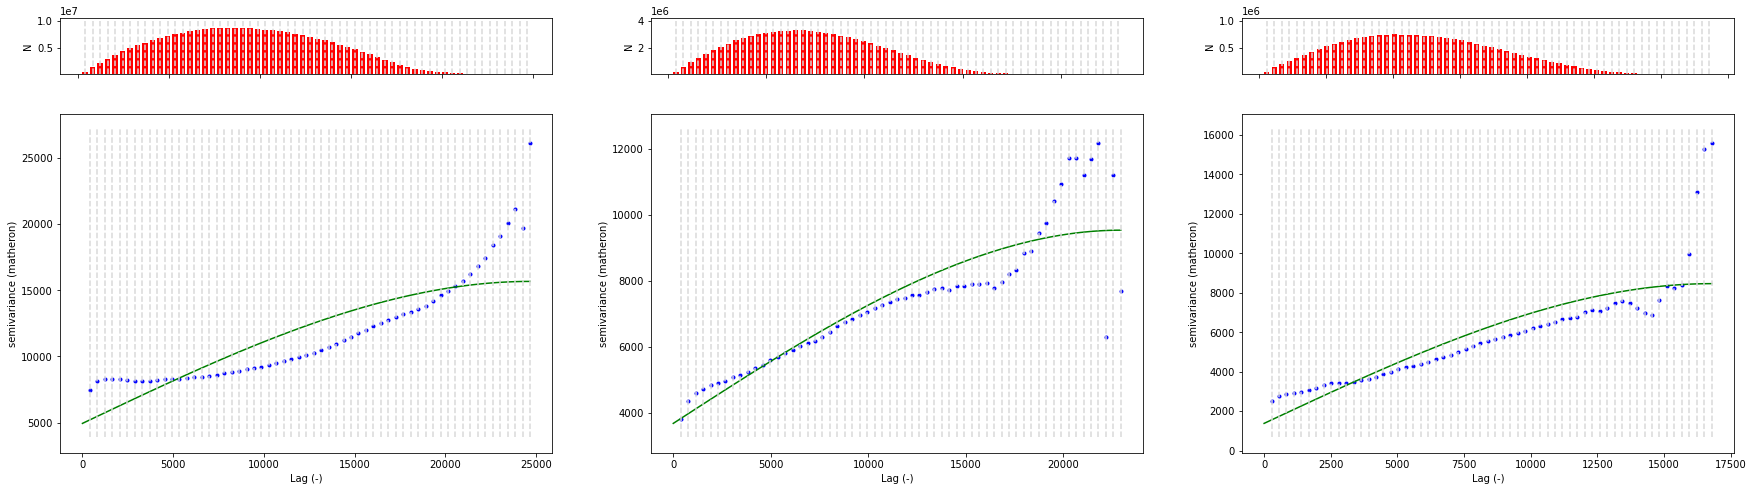

In [59]:
f,ax=plt.subplots(2,3,figsize=(30,8),sharey=False,gridspec_kw={'height_ratios': [1, 6]})
V_full = get_semivariogram(stats_full_df,'runoff_dates',sampling_frac=0.03);
V_full.plot(axes=ax[::-1,0]);
V_ndvi = get_semivariogram(stats_ndvi_mask_df,'runoff_dates',sampling_frac=0.03);
V_ndvi.plot(axes=ax[::-1,1]);
V_gm = get_semivariogram(stats_glacier_mask_df,'runoff_dates',sampling_frac=0.03);
V_gm.plot(axes=ax[::-1,2]);
#V.scattergram();
#V.distance_difference_plot();

In [103]:
def get_morans_local_i(stats_df,sampling_frac=.001):
    # to avoid spatial autocorrelation we must sample
    # https://www.statisticshowto.com/morans-i/
    # https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018WR022553
    # calculating moran's i for the sample
    # https://geographicdata.science/book/notebooks/07_local_autocorrelation.html

    stats_df = stats_df.sample(frac=sampling_frac)
    w = weights.distance.KNN.from_dataframe(stats_df, k=8)
    # Row-standardization
    w.transform = 'R'
    lisa = esda.moran.Moran_Local(stats_df['runoff_dates'], w)
    stats_df['moran_i'] = lisa.Is
    stats_df['moran_i_p_val'] = lisa.p_sim
    stats_df['moran_i_p_val_sig'] = stats_df['moran_i_p_val'] < 0.05
    return stats_df, lisa

In [104]:
def plot_morans_local_i(stats_df,sampling_frac=0.01):
    
    
    stats_ds = stats_df.to_xarray()
    stats_df,lisa=get_morans_local_i(stats_full_df,sampling_frac=sampling_frac)
    
    seaborn.kdeplot(lisa.Is,ax=ax[0])
    seaborn.rugplot(lisa.Is,ax=ax[0])
    ax[0].set_title('Morans I PDF')

    stats_ds['runoff_dates'].plot(ax=ax[1],cmap='Greys_r')
    #stats_full_df.plot.scatter(x='x',y='y',c='white',ax=ax[1])
    #stats_full_ds['moran_i'].plot(vmin=-1,vmax=1)
    stats_df.reset_index().plot.scatter(x='x',y='y',c='moran_i', cmap='plasma',s=5,legend=True,ax=ax[1])
    ax[1].set_title('Spatial Distribution of Morans I')


    stats_ds['runoff_dates'].plot(ax=ax[2],cmap='Greys_r')
    stats_df[stats_full_df['moran_i_p_val_sig']].reset_index().plot.scatter(x='x',y='y',c='r',legend=True,ax=ax[2],s=5)
    stats_df[~stats_full_df['moran_i_p_val_sig']].reset_index().plot.scatter(x='x',y='y',c='b',legend=True,ax=ax[2],s=5)
    ax[2].set_title('Moran I Significance \n (Red=Significant, Blue=Not Significant)') # red is spatially correlated, blue is not

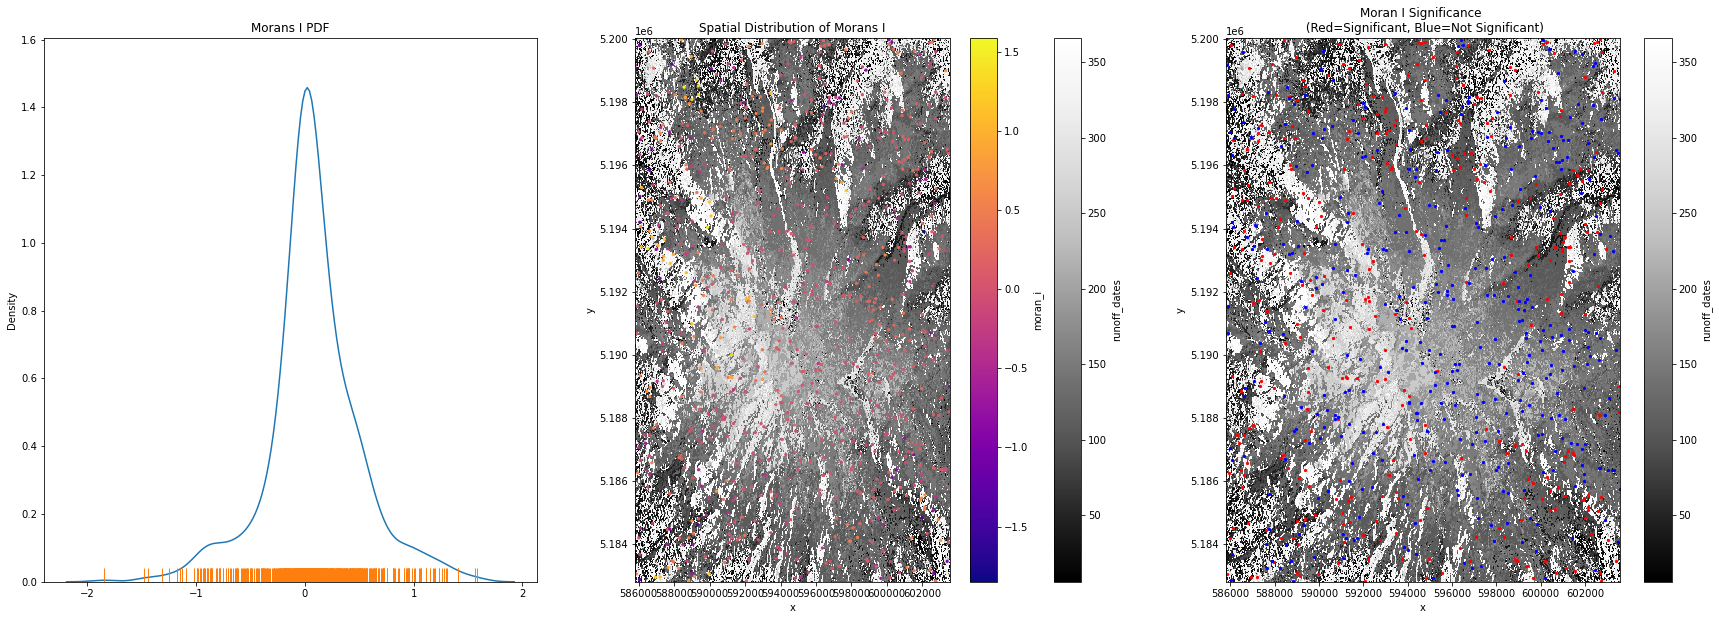

In [105]:
f,ax = plt.subplots(1,3,figsize=(30,10))
plot_morans_local_i(stats_full_df,sampling_frac=0.001)

In [107]:
def get_morans_global_i(stats_df,sampling_frac=.001):
    # to avoid spatial autocorrelation we must sample
    # https://www.statisticshowto.com/morans-i/
    # https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018WR022553
    # calculating moran's i for the sample
    # https://geographicdata.science/book/notebooks/07_local_autocorrelation.html

    stats_df = stats_df.sample(frac=sampling_frac)
    w = weights.distance.KNN.from_dataframe(stats_df, k=8)
    # Row-standardization
    w.transform = 'R'
    moran = esda.moran.Moran(stats_df['runoff_dates'], w)
    #stats_df['moran_i'] = lisa.Is
    #stats_df['moran_i_p_val'] = lisa.p_sim
    #stats_df['moran_i_p_val_sig'] = stats_df['moran_i_p_val'] < 0.05
    return moran

In [108]:
mor = get_morans_global_i(stats_full_df)

In [119]:
def plot_morans_global_i(stats_df,sampling_frac=.001):
    moran = get_morans_global_i(stats_df,sampling_frac=sampling_frac)
    plot_moran(moran)

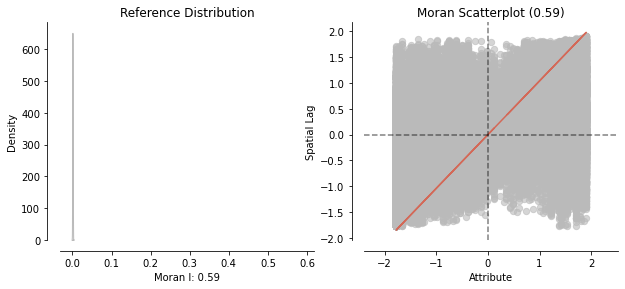

In [133]:
plot_morans_global_i(stats_full_df,sampling_frac=1)